In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import pandas as pd
import cv2

plt.ion()   # interactive mode

In [2]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '../data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=96,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
dataset_sizes

{'train': 621772, 'val': 263}

In [4]:
class_names

['Female', 'Male']

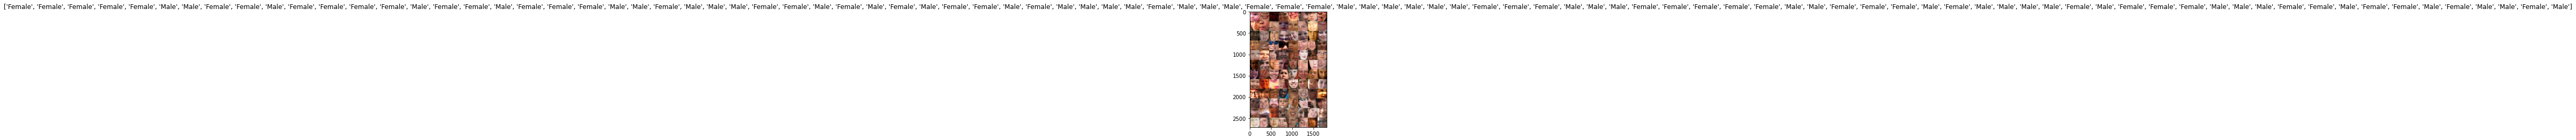

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
model_ft = models.resnet152(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.4269 Acc: 0.8048
val Loss: 0.2276 Acc: 0.9163

Epoch 1/9
----------
train Loss: 0.3635 Acc: 0.8477
val Loss: 0.1884 Acc: 0.9240

Epoch 2/9
----------
train Loss: 0.3457 Acc: 0.8585
val Loss: 0.1984 Acc: 0.9468

Epoch 3/9
----------
train Loss: 0.3352 Acc: 0.8647
val Loss: 0.1743 Acc: 0.9392

Epoch 4/9
----------
train Loss: 0.3264 Acc: 0.8695
val Loss: 0.1849 Acc: 0.9468

Epoch 5/9
----------
train Loss: 0.3214 Acc: 0.8722
val Loss: 0.1873 Acc: 0.9354

Epoch 6/9
----------
train Loss: 0.3159 Acc: 0.8753
val Loss: 0.1968 Acc: 0.9506

Epoch 7/9
----------
train Loss: 0.3039 Acc: 0.8815
val Loss: 0.1781 Acc: 0.9468

Epoch 8/9
----------
train Loss: 0.3015 Acc: 0.8824
val Loss: 0.1723 Acc: 0.9544

Epoch 9/9
----------
train Loss: 0.2999 Acc: 0.8833
val Loss: 0.1742 Acc: 0.9468

Training complete in 1251m 40s
Best val Acc: 0.954373


In [10]:
state = {'net':model_ft.state_dict(), 'optimizer':optimizer_ft.state_dict(), 'epoch':1}
torch.save(state, "model.pth")

In [22]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/home/zzl/8360-p2/data/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
print(image_datasets)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=96,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

{'train': Dataset ImageFolder
    Number of datapoints: 621772
    Root location: /home/zzl/8360-p2/data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'val': Dataset ImageFolder
    Number of datapoints: 263
    Root location: /home/zzl/8360-p2/data/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )}


In [23]:
data_dir = '/home/zzl/8360-p2/data/X_test/'
test_list =['X_a', 'X_b', 'X_c']

In [24]:
data_transforms = {
    'X_a': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'X_b': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'X_c': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [25]:
from torch.utils.data import Dataset
import natsort
from PIL import Image

In [26]:
data_dir = '/home/zzl/8360-p2/data/X_test/'

In [27]:
class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = natsort.natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return tensor_image, self.total_imgs[idx]

In [28]:
def test(model, data_dir, test_list):   
    pred_dict_A = {}
    pred_dict_B = {}
    pred_dict_C = {}
   
    image_datasets = {x: CustomDataSet(os.path.join(data_dir, x),
                                          data_transforms[x]) for x in test_list}
    
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1,
                                                 shuffle=False, num_workers=4) for x in test_list}
    for phase in test_list:
        for inputs, labels in dataloaders[phase]:
            outputs = model(inputs.cuda())
            _, preds = torch.max(outputs, 1)
            if phase == "X_a":
                pred_dict_A[labels[0]] = preds.cpu().numpy()[0]
            if phase == "X_b":
                pred_dict_B[labels[0]] = preds.cpu().numpy()[0]
            if phase == "X_c":
                pred_dict_C[labels[0]] = preds.cpu().numpy()[0]
            
    return pred_dict_A, pred_dict_B, pred_dict_C

In [29]:
pred_dict_A, pred_dict_B, pred_dict_C = test(model_ft, data_dir, test_list)

In [30]:
def get_result(pred_dict, df, save_name):
    with open(save_name, 'w') as f:
        for index, row in df.iterrows():
            f.write("%s\n"%pred_dict[row["Image File"]])

In [31]:
def get_result(pred_dict, df, save_name):
    key_list=[]
    for index, row in df.iterrows():
        key = row['Image File']
        if key not in key_list:
            key_list.append(key)
    with open(save_name, 'w') as f:
        for key in key_list:
            f.write("%s\n"%pred_dict[key])

In [32]:
data_X_a_test = pd.read_csv("/home/zzl/8360-p2/data/Xa_test.csv")
data_X_b_test = pd.read_csv("/home/zzl/8360-p2/data/Xb_test.csv")
data_X_c_test = pd.read_csv("/home/zzl/8360-p2/data/Xc_test.csv")

In [33]:
get_result(pred_dict_A, data_X_a_test, "/home/zzl/8360-p2/data/ya.txt")
get_result(pred_dict_B, data_X_b_test, "/home/zzl/8360-p2/data/yb.txt")
get_result(pred_dict_C, data_X_c_test, "/home/zzl/8360-p2/data/yc.txt")